<a href="https://colab.research.google.com/github/avishreekh/Confusion-detection-EEG/blob/master/Confusion_Detection_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import sklearn
from sklearn.preprocessing import scale, normalize
from sklearn.model_selection import train_test_split, StratifiedKFold
import scipy
from scipy.signal import spectrogram
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate, Dropout, BatchNormalization, Bidirectional
from keras.layers import LSTM, GRU

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [2]:
!git clone https://github.com/avishreekh/Confusion-detection-EEG.git

Cloning into 'Confusion-detection-EEG'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 18 (delta 4), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [0]:
eeg_data = "/content/Confusion-detection-EEG/data/EEG_data.csv"
demo_data = "/content/Confusion-detection-EEG/data/demographic_info.csv"

In [4]:
eeg_df = pd.read_csv(eeg_data)
eeg_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [5]:
eeg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12811 entries, 0 to 12810
Data columns (total 15 columns):
SubjectID             12811 non-null float64
VideoID               12811 non-null float64
Attention             12811 non-null float64
Mediation             12811 non-null float64
Raw                   12811 non-null float64
Delta                 12811 non-null float64
Theta                 12811 non-null float64
Alpha1                12811 non-null float64
Alpha2                12811 non-null float64
Beta1                 12811 non-null float64
Beta2                 12811 non-null float64
Gamma1                12811 non-null float64
Gamma2                12811 non-null float64
predefinedlabel       12811 non-null float64
user-definedlabeln    12811 non-null float64
dtypes: float64(15)
memory usage: 1.5 MB


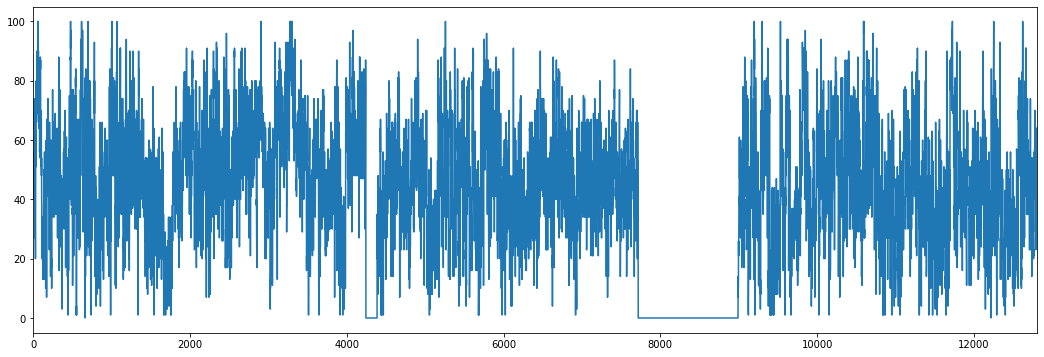

In [6]:
eeg_df['Attention'].plot(figsize=(18,6))
plt.show()

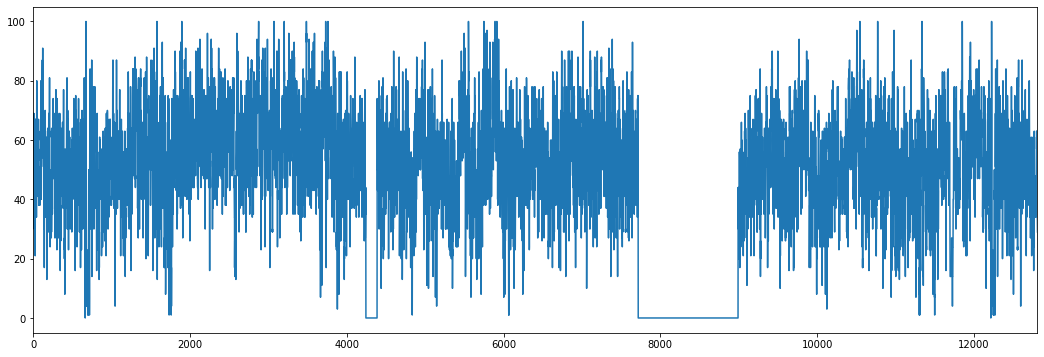

In [7]:
eeg_df['Mediation'].plot(figsize=(18,6))
plt.show()

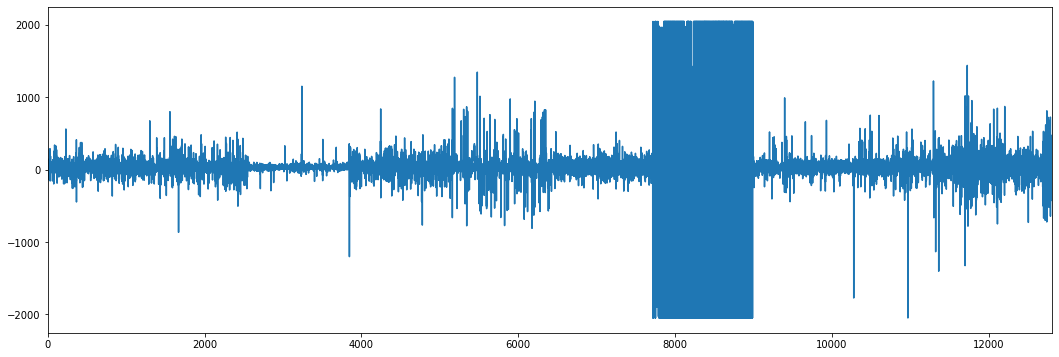

In [8]:
eeg_df['Raw'].plot(figsize=(18,6))
plt.show()

It can be seen that there are certain rows with misleading data. As they appear together, it could be from a single user.


In [9]:
eeg_df.groupby(['SubjectID', 'VideoID']).filter(lambda x: x['Attention'].sum()==0).groupby(['SubjectID', 'VideoID']).size()

SubjectID  VideoID
3.0        3.0        144
6.0        0.0        140
           1.0        142
           2.0        122
           3.0        116
           4.0        144
           5.0        123
           6.0        116
           7.0        113
           8.0        122
           9.0        137
dtype: int64

**Data Cleaning** : So **all the data entries from Subject 6** have probelms and so do **entry from video 3 for subject 3**. Rest all data entries seem fine, and only these have to be **removed**. 

In [10]:
data = eeg_df.query('(SubjectID != 6) & (SubjectID != 3 | VideoID !=3)')
len(data), len(eeg_df)

(11392, 12811)

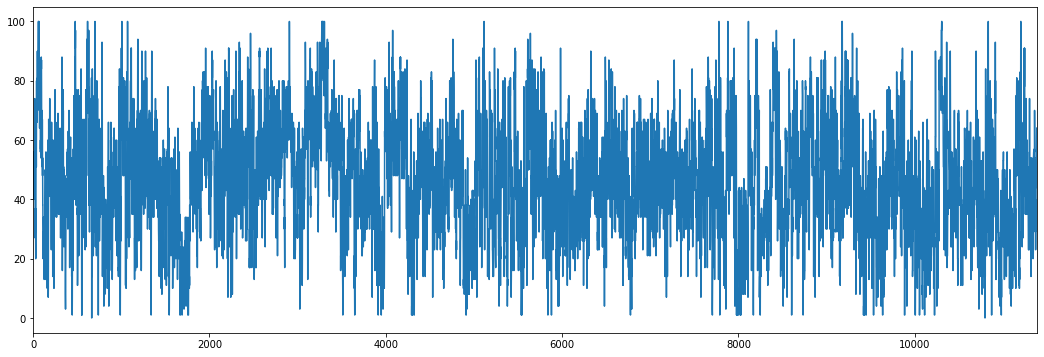

In [11]:
data.reset_index()['Attention'].plot(figsize=(18,6))
plt.show()

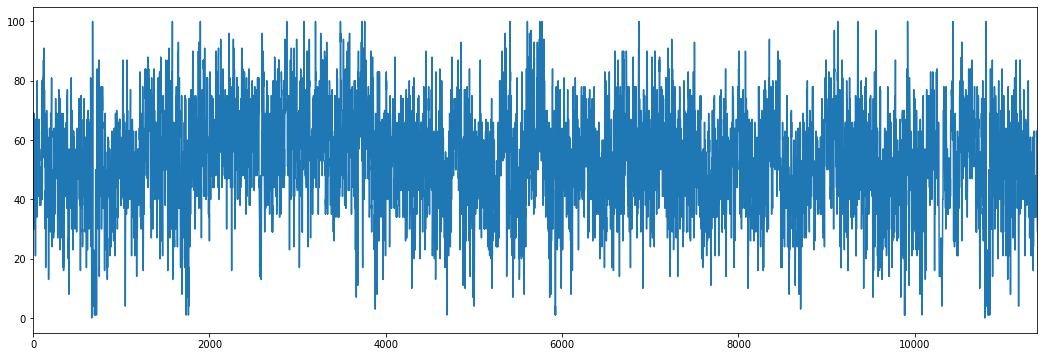

In [12]:
data.reset_index()['Mediation'].plot(figsize=(18,6))

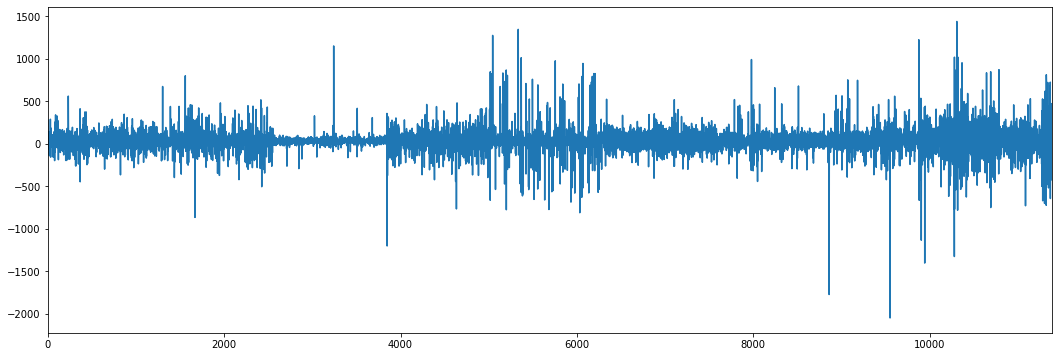

In [13]:
data.reset_index()['Raw'].plot(figsize=(18,6))

We now have continuous data entries.


In [0]:
corr = data.corr()
corr

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
SubjectID,1.000000,-0.008905,-0.113540,-0.092033,-0.001363,0.206455,0.111413,0.111729,0.140214,0.059720,0.144859,0.054789,0.029171,-0.008334,0.014027
VideoID,-0.008905,1.000000,-0.071697,-0.005977,-0.000819,0.003283,0.017466,0.024436,-0.003978,0.023950,-0.025139,-0.001777,0.017863,0.872185,0.014883
Attention,-0.113540,-0.071697,1.000000,0.162696,-0.008388,-0.237335,-0.272586,-0.187214,-0.156197,-0.125265,0.018580,-0.074249,-0.040691,-0.027861,-0.200929
Mediation,-0.092033,-0.005977,0.162696,1.000000,0.016321,-0.088904,-0.168171,0.065489,0.044051,-0.049912,-0.089450,-0.074629,-0.094584,-0.015472,-0.087938
Raw,-0.001363,-0.000819,-0.008388,0.016321,1.000000,-0.008388,-0.003858,-0.014944,-0.011935,-0.044504,-0.018658,-0.011208,-0.023205,-0.001651,0.000167
Delta,0.206455,0.003283,-0.237335,-0.088904,-0.008388,1.000000,0.485276,0.434420,0.415134,0.410677,0.385174,0.392043,0.310033,0.009265,0.159459
Theta,0.111413,0.017466,-0.272586,-0.168171,-0.003858,0.485276,1.000000,0.600374,0.584821,0.597776,0.491882,0.486883,0.415539,0.019975,0.148249
Alpha1,0.111729,0.024436,-0.187214,0.065489,-0.014944,0.434420,0.600374,1.000000,0.557952,0.561410,0.461468,0.485648,0.376634,0.026873,0.120295
Alpha2,0.140214,-0.003978,-0.156197,0.044051,-0.011935,0.415134,0.584821,0.557952,1.000000,0.589906,0.557673,0.532398,0.365821,0.002110,0.101898
Beta1,0.059720,0.023950,-0.125265,-0.049912,-0.044504,0.410677,0.597776,0.561410,0.589906,1.000000,0.464235,0.492587,0.486344,0.027741,0.124998


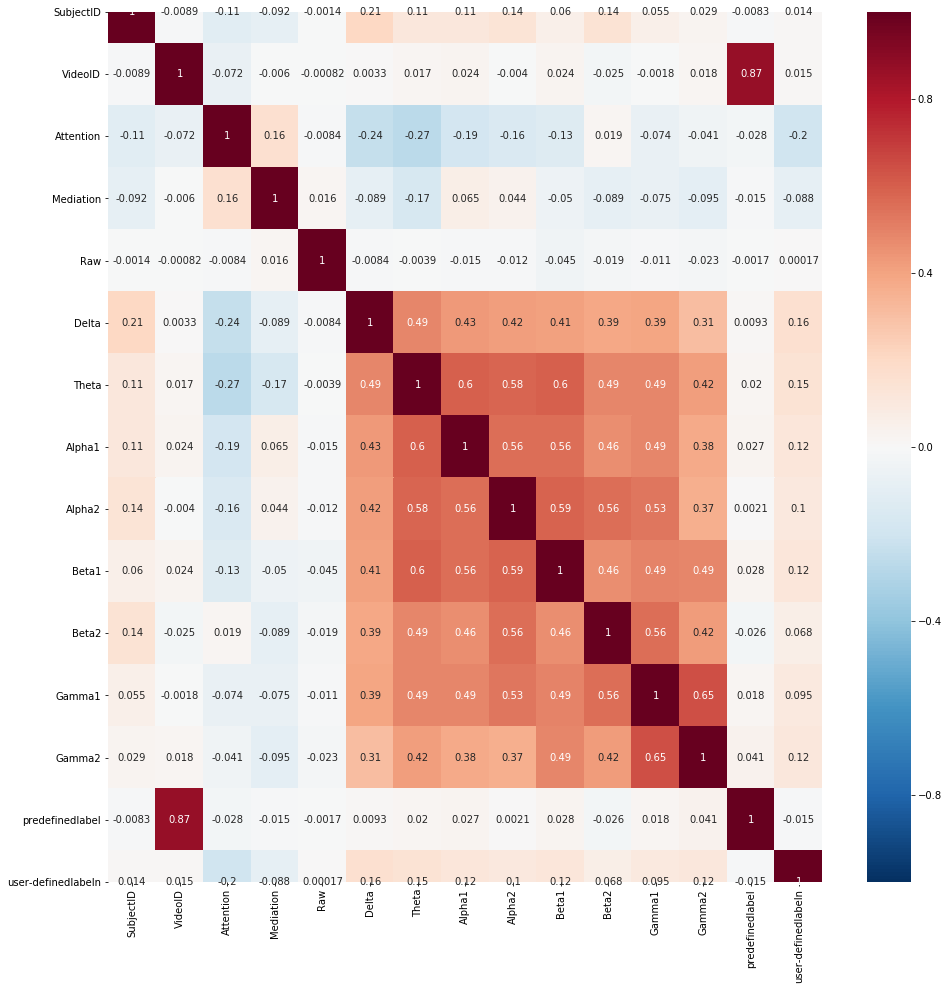

In [0]:
plt.figure(figsize = (16, 16))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap="RdBu_r")
plt.show()


Correlation matrix and corresponding heatmap.

#Method 1: Only using delta and theta waves

#Preprocessing of data

In [0]:
deltas = []
thetas = []
labels = []
sub_ids = data['SubjectID'].unique()
vid_ids = data['VideoID'].unique()

for sid in sub_ids:
  for vid in vid_ids:
    point = data.query('SubjectID ==' + str(sid) + ' & VideoID ==' + str(vid))
    if (len(point) > 0):
      labels.append(point['user-definedlabeln'].unique()[0])
      deltas.append(point['Delta'].values)
      thetas.append(point['Theta'].values)


In [9]:
print(len(deltas), len(thetas), len(labels))

89 89 89


In [0]:
seq_len = 144
deltas_fin=sequence.pad_sequences(deltas, maxlen=seq_len, padding='post', dtype='float', truncating='post')
thetas_fin=sequence.pad_sequences(thetas, maxlen=seq_len, padding='post', dtype='float', truncating='post')
deltas_fin = np.asarray(deltas_fin)
thetas_fin = np.asarray(thetas_fin)
labels = np.asarray(labels)

In [11]:
print(len(deltas_fin), len(thetas_fin), len(labels))

89 89 89


In [16]:
X_train_delta, X_test_delta, X_train_theta, X_test_theta, y_train, y_test = train_test_split(deltas_fin, thetas_fin, labels, test_size=0.1, random_state=42)
print(X_train_delta.shape, X_test_delta.shape, X_train_theta.shape, X_test_theta.shape, y_train.shape, y_test.shape) 

(80, 144) (9, 144) (80, 144) (9, 144) (80,) (9,)


In [17]:
X_train_delta = np.reshape(X_train_delta, (X_train_delta.shape[0], 1, X_train_delta.shape[1]))
X_train_theta = np.reshape(X_train_theta, (X_train_theta.shape[0], 1, X_train_theta.shape[1]))
X_test_delta = np.reshape(X_test_delta, (X_test_delta.shape[0], 1, X_test_delta.shape[1]))
X_test_theta = np.reshape(X_test_theta, (X_test_theta.shape[0], 1, X_test_theta.shape[1]))
print(X_train_delta.shape, X_test_delta.shape, X_train_theta.shape, X_test_theta.shape, y_train.shape, y_test.shape) 

(80, 1, 144) (9, 1, 144) (80, 1, 144) (9, 1, 144) (80,) (9,)


To do:
1. Use all waves for processing
2. Use median or min for padding and truncation

#Defining the model

In [14]:
input_delta = Input((1,144), name='input_delta')
input_theta = Input((1,144), name='input_theta')
lstm_out_delta = LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(input_delta)
lstm_out_theta = LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)(input_theta)
merged = concatenate([lstm_out_delta, lstm_out_theta])
out = Dense(64, activation='relu', kernel_initializer='he_uniform')(merged)
out = Dropout(0.5)(out)
main_out = Dense(1, activation='sigmoid')(out)

model3 = Model([input_delta, input_theta], main_out)
model3.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_delta (InputLayer)        (None, 1, 144)       0                                            
__________________________________________________________________________________________________
input_theta (InputLayer)        (None, 1, 144)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           53504       input_delta[0][0]                
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           53504       input_t

In [15]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
model3.fit(x=[X_train_delta, X_train_theta], batch_size=1, y=y_train, epochs=10, validation_split=0.1)




Train on 72 samples, validate on 8 samples
Epoch 1/10





72/72 [==============================] - 3s 46ms/step - loss: 0.7344 - acc: 0.5000 - val_loss: 0.7507 - val_acc: 0.2500
Epoch 2/10
72/72 [==============================] - 0s 7ms/step - loss: 0.7729 - acc: 0.4306 - val_loss: 0.7456 - val_acc: 0.2500
Epoch 3/10
72/72 [==============================] - 0s 6ms/step - loss: 0.7294 - acc: 0.4861 - val_loss: 0.7422 - val_acc: 0.2500
Epoch 4/10
72/72 [==============================] - 0s 6ms/step - loss: 0.6521 - acc: 0.5694 - val_loss: 0.7481 - val_acc: 0.3750
Epoch 5/10
72/72 [==============================] - 1s 7ms/step - loss: 0.6978 - acc: 0.5278 - val_loss: 0.7201 - val_acc: 0.3750
Epoch 6/10
72/72 [==============================] - 1s 8ms/step - loss: 0.6672 - acc: 0.5833 - val_loss: 0.7445 - val_acc: 0.3750
Epoch 7/10
72/72 [==============================] - 1s 8ms/step - loss: 0.6425 - acc: 0.6111 - val_loss: 0.7396 - val_acc: 0.2500
Epoch 8/10
72/72 [====================

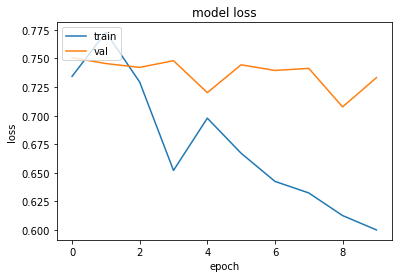

In [18]:
history = model3.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#Method 2: Using all the waves given

-Using only the first 112 timesteps

In [0]:
waves = []
labels = []
sub_ids = data['SubjectID'].unique()
vid_ids = data['VideoID'].unique()

for sid in sub_ids:
  for vid in vid_ids:
    point = data.query('SubjectID ==' + str(sid) + ' & VideoID ==' + str(vid))
    if (len(point) > 0):
      labels.append(point['user-definedlabeln'].unique()[0])
      waves.append(point.iloc[:112, 2:13].values)

In [0]:
# len(waves)
waves = np.asarray(waves)
labels = np.asarray(labels)

Using train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(waves, labels, test_size=0.1, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) 

(80, 112, 11) (9, 112, 11) (80,) (9,)


In [0]:
model = Sequential()
model.add(BatchNormalization(axis=1))
# model.add(Bidirectional(LSTM(5, dropout=0.5, recurrent_dropout=0.5)))
model.add(GRU(12,dropout=0.5,recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.build((None, 112, 11))

In [111]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_14 (Batc (None, 112, 11)           448       
_________________________________________________________________
gru_6 (GRU)                  (None, 30)                3780      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 31        
Total params: 4,259
Trainable params: 4,035
Non-trainable params: 224
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [126]:
model.fit(x=waves, y=labels, batch_size=10, epochs=10,validation_split=0.1)

Train on 80 samples, validate on 9 samples
Epoch 1/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6829 - acc: 0.5250 - val_loss: 0.7244 - val_acc: 0.5556
Epoch 2/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6827 - acc: 0.5875 - val_loss: 0.7289 - val_acc: 0.5556
Epoch 3/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6869 - acc: 0.5375 - val_loss: 0.7323 - val_acc: 0.5556
Epoch 4/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6542 - acc: 0.5875 - val_loss: 0.7355 - val_acc: 0.5556
Epoch 5/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6747 - acc: 0.5625 - val_loss: 0.7363 - val_acc: 0.5556
Epoch 6/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6840 - acc: 0.5000 - val_loss: 0.7340 - val_acc: 0.6667
Epoch 7/10
80/80 [==============================] - 1s 7ms/step - loss: 0.6622 - acc: 0.6000 - val_loss: 0.7335 - val_acc: 0.5556
Epoch 8/10
80/80 [=============================

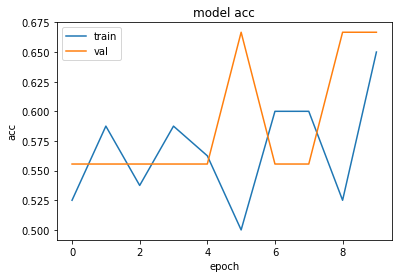

In [127]:
history = model.history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

Using Stratified 5-fold cross-validation

In [43]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
losses = []
# create model
model = Sequential()
model.add(BatchNormalization())
# model.add(Bidirectional(LSTM(50, dropout=0.2, recurrent_dropout=0.2)))
model.add(GRU(25,dropout=0.5,recurrent_dropout=0.2))
# model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
	# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

for train, test in kfold.split(waves, labels):
  # Fit the model
  model.fit(waves[train], labels[train], epochs=5, batch_size=20,verbose=0)
  losses.append(model.history.history['loss'])
	# evaluate the model
  scores = model.evaluate(waves[test], labels[test], verbose=1)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

19/19 [==============================] - 1s 59ms/step
acc: 63.16%
18/18 [==============================] - 0s 512us/step
acc: 72.22%
18/18 [==============================] - 0s 523us/step
acc: 61.11%
17/17 [==============================] - 0s 669us/step
acc: 64.71%
17/17 [==============================] - 0s 547us/step
acc: 70.59%
66.36% (+/- 4.31%)


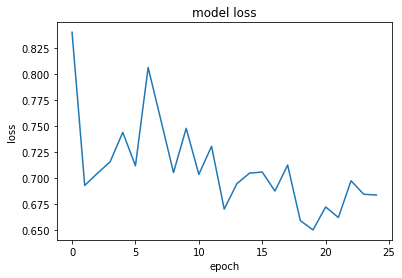

In [44]:
# history = model.history
losses = [lol for loss in losses for lol in loss]
plt.plot(range(25), losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
from sklearn.metrics import classification_report

In [45]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = []
for i in y_pred:
  if i >= 0.5:
    y_pred_bool.append(1.)
  else :
    y_pred_bool.append(0.)

print(classification_report(y_test, y_pred_bool))

9/9 [==============================] - 1s 122ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92         7
         1.0       0.67      1.00      0.80         2

    accuracy                           0.89         9
   macro avg       0.83      0.93      0.86         9
weighted avg       0.93      0.89      0.90         9



In [46]:
acc = sum(y_pred_bool == y_test)
print(y_pred_bool)
print(y_test)
print(acc/len(y_test))

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
[0. 0. 0. 1. 0. 0. 1. 0. 0.]
0.8888888888888888
